# Vastly inspired from A. Roodman "imagemosaic"

## Setup and imports

In [1]:
! eups list -s lsst_distrib

   gdf42428520+d521942ec3 	current w_2023_21 setup


In [2]:
# plotting
import pylab as plt
import numpy as np

# butler
from lsst.daf.butler import Butler

# isr and display
import lsst.afw.display as afwDisplay
from lsst.ip.isr.isrTask import IsrTask
from lsst.cp.pipe.cpCombine import CalibCombineTask

# camera stuff
import lsst.afw.math as afwMath
from lsst.afw.cameraGeom import utils as cgu
from lsst.obs.lsst import LsstCam

# Astropy nice plotting
from astropy.visualization import imshow_norm, MinMaxInterval, AsinhStretch, LinearStretch, \
                                  SqrtStretch,ContrastBiasStretch,ZScaleInterval, \
                                  AsymmetricPercentileInterval,ManualInterval


## Helpers

In [3]:
def displayExposure(exposure,title=None):
    afwDisplay.setDefaultBackend('matplotlib') 
    afw_display.setImageColormap(cmap='gray')
    fig = plt.figure(figsize=(10,10))
    afw_display = afwDisplay.Display(1)
    afw_display.scale('asinh', 'zscale')
    afw_display.mtv(exposure.getImage())
    plt.title(title)
    plt.gca().axis('off')
    return afw_display

def displayImage(image,title=None):
    afwDisplay.setDefaultBackend('matplotlib') 
    fig = plt.figure(figsize=(10,10))
    afw_display = afwDisplay.Display(1)
    afw_display.scale('asinh', 'zscale')
    #afw_display.scale('linear', min=-5, max=10)
    afw_display.setImageColormap(cmap='plasma')
    afw_display.mtv(image)
    plt.title(title)
    plt.gca().axis('off')
    return afw_display

def displayImageGhosts(image,title=None):
    afwDisplay.setDefaultBackend('matplotlib') 
    fig = plt.figure(figsize=(10,10))
    afw_display = afwDisplay.Display(1)
    #afw_display.scale('asinh', 'zscale')
    afw_display.scale('linear', min=0, max=10)
    afw_display.setImageColormap(cmap='plasma')
    afw_display.mtv(image)
    plt.title(title)
    plt.gca().axis('off')
    return afw_display

In [4]:
def getRefsFromObsId(butler, obs_id="MC_C_20230619_000087", detector=None):
    if detector is not None:
        refs = list(set(butler.registry.queryDatasets(datasetType='raw',
                                                  instrument='LSSTCam',
                                                  where=f"exposure.obs_id='{obs_id}'",
                                                  detector=detector)))
        print(f'Found {len(refs)} CCD exposure.')
        # print(butler.get(refs[0]).info.getDetector().getName())

    else:
        refs = list(set(butler.registry.queryDatasets(datasetType='raw',
                                                  instrument='LSSTCam',
                                                  where=f"exposure.obs_id='{obs_id}'")))
        print(f'Found {len(refs)} CCD exposures.')
        # print(butler.get(refs[0]).info.getVisitInfo())
    exposure_refs = {ref.dataId['detector']: ref for ref in refs}
    return exposure_refs



In [5]:
def show_hv_slices(imgarray, vpix, hpix, ccdname):
    plt.rcParams["figure.figsize"] = [12, 6]
    fig, ax = plt.subplots(1, 2)
    subax = imgarray[vpix]
    x = range(len(subax))
    ax[0].plot(x, subax)
    ax[0].set_title(f'Horizontal slice on {ccdname} at pixel {vpix}')
    subay = np.transpose(imgarray)[hpix]
    y = range(len(subay))
    ax[1].plot(y, subay)
    ax[1].set_title(f'Vertical slice on {ccdname} at pixel {hpix}')


## Make mosaic functions

In [6]:
def run_isr_raw_ccd(raw):
    isr = IsrTask()
    isr.config.doLinearize=False
    isr.config.doDark=False
    isr.config.doBias=False
    isr.config.doFlat=False
    isr.config.doDefect=False
    isr.config.overscan.fitType: 'MEDIAN_PER_ROW'  # 'MEDIAN'  # 'MEDIAN_PER_ROW'
    isr.config.overscan.doParallelOverscan=False
    postISRCCD = isr.run(raw)
    # show individual ccds
    #displayExposure(postISRCCD.exposure, raw.getMetadata()["FILENAME"])
    #plt.show()
    return postISRCCD

class CcdImageSource:
    isTrimmed = True
    background = 0.0

    def __init__(self, butler, exposure_refs, idNameMap):
        self.butler = butler
        self.exposure_refs = exposure_refs
        self.idNameMap = idNameMap

    def getCcdImage(self, det, imageFactory, binSize=8, *args, **kwargs):
        ccd_name = det.getName()
        det_id = self.idNameMap[ccd_name]
        print(ccd_name, det_id)
        raw=self.butler.get(self.exposure_refs[det_id])

        isred = run_isr_raw_ccd(raw)
        ccd = isred.exposure.getImage()
        ccdImage = afwMath.binImage(ccd, binSize)
        rotccd = afwMath.rotateImageBy90(ccdImage, det.getOrientation().getNQuarter())
        return rotccd, det

def makeMosaicForObsId(butler, obsId, reqDetectorNameList, binSize):
    # get exposure references for all detectors as dict with key=id detector
    exposure_refs = getRefsFromObsId(butler, obs_id=obsId)
    # build a camera
    camera = LsstCam.getCamera()
    # available detectors
    avDetectorNameList = [camera[detector].getName() for detector in exposure_refs]
    # name id map
    idNameMap = {camera[detector].getName(): detector for detector in exposure_refs}

    # intersection of requested and available
    detectorNameList = avDetectorNameList
    if len(reqDetectorNameList)>0:
        detectorNameList = list(set(reqDetectorNameList) & set(avDetectorNameList))
        
    # image source
    image_source = CcdImageSource(butler, exposure_refs, idNameMap)
    return cgu.showCamera(camera, imageSource=image_source,
                          detectorNameList=detectorNameList,
                          binSize=binSize)


In [7]:
# stolen from Aaron
from mpl_toolkits import axes_grid1

def array_from_mosaic(mosaic):
    mar = mosaic.getArray()
    mma= np.ma.filled(np.ma.masked_values(mar,0.0000),np.nan)
    return mma

def add_colorbar(im, aspect=20, pad_fraction=0.5, **kwargs):
    """Add a vertical color bar to an image plot."""
    divider = axes_grid1.make_axes_locatable(im.axes)
    width = axes_grid1.axes_size.AxesY(im.axes, aspect=1./aspect)
    pad = axes_grid1.axes_size.Fraction(pad_fraction, width)
    current_ax = plt.gca()
    cax = divider.append_axes("right", size=width, pad=pad)
    plt.sca(current_ax)
    return im.axes.figure.colorbar(im, cax=cax, **kwargs)

def show_mosaic(mosaic):
    mma = array_from_mosaic(mosaic)
    fig,ax = plt.subplots(1,1,figsize=(10.,10.))
    im, norm = imshow_norm(mma, ax, origin='lower', interpolation='None', cmap='plasma',
                       stretch=LinearStretch())
    add_colorbar(im)
    return fig

## Connect to the Butler repository

In [8]:
repo_path = "/sdf/data/rubin/repo/ir2"
butler = Butler(repo_path)
collections = 'LSSTCam/raw/all,LSSTCam/calib'.split(",")
butler = Butler(repo_path,collections=collections)
registry = butler.registry

In [9]:
# circles = "MC_C_20230622_000357"
# nice ghosts = "MC_C_20230625_000403" (401 (1s), 405, 409, 411)
obs_id_to_process = "MC_C_20230625_000401"
imgtag = "medperrow"
my_detectors = ['R22_S00', 'R22_S01', 'R22_S02', 'R22_S10', 'R22_S11', 'R22_S12', 'R22_S20', 'R22_S21', 'R22_S22']
#                ,'R21_S10', 'R21_S11', 'R21_S12', 'R32_S01', 'R32_S11', 'R32_S21'] 

# process some detectors
#mosaic = makeMosaicForObsId(butler, obsId=obs_id_to_process, reqDetectorNameList=my_detectors, binSize=8)
# process all
mosaic = makeMosaicForObsId(butler, obsId=obs_id_to_process, reqDetectorNameList=[], binSize=8)

Found 205 CCD exposures.
R34_S20 159


R34_S10 156


R31_S22 134


R11_S11 40


R23_S01 100


R40_SG1 198


R11_S12 41


R00_SG0 189


R33_S00 144


R41_S20 168


R21_S01 82


R04_SG0 193


R31_S00 126


R13_S01 55


R24_S00 108


R34_S00 153


R12_S20 51


R20_S22 80


R43_S01 181


R34_S11 157


R34_S12 158


R41_S21 169


R10_S21 34


R23_S10 102


R42_S00 171


R33_S01 145


R23_S12 104


R20_S20 78


R32_S10 138


R21_S21 88


R43_S11 184


R14_S01 64


R43_S00 180


R02_S01 10


R23_S22 107


R03_S22 26


R20_S11 76


R03_S01 19


R34_S01 154


R02_S20 15


R21_S00 81


R43_S10 183


R11_S02 38


R41_S02 164


R32_S02 137


R30_S12 122


R13_S21 61


R40_SW1 200


R21_S20 87


R12_S11 49


R11_S10 39


R41_S11 166


R42_S21 178


R10_S10 30


R11_S00 36


R02_S02 11


R01_S00 0


R02_S21 16


R30_S00 117


R41_S10 165


R33_S02 146


R14_S22 71


R21_S22 89


R01_S12 5


R31_S20 132


R12_S02 47


R01_S02 2


R21_S12 86


R13_S12 59


R13_S20 60


R12_S01 46


R23_S02 101


R42_S11 175


R43_S12 185


R01_S20 6


R31_S21 133


R22_S11 94


R23_S11 103


R30_S22 125


R42_S10 174


R40_SG0 197


R01_S11 4


R44_SW1 204


R10_S02 29


R32_S12 140


R12_S00 45


R02_S10 12


R12_S21 52


R02_S22 17


R22_S10 93


R14_S00 63


R12_S22 53


R01_S21 7


R30_S01 118


R34_S21 160


R13_S22 62


R43_S22 188


R10_S12 32


R13_S10 57


R32_S00 135


R23_S21 106


R22_S22 98


R33_S12 149


R30_S11 121


R11_S01 37


R34_S22 161


R22_S12 95


R03_S10 21


R33_S21 151


R24_S22 116


R03_S02 20


R24_S20 114


R02_S00 9


R20_S02 74


R24_S12 113


R00_SG1 190


R32_S21 142


R02_S12 14


R14_S12 68


R44_SW0 203


R32_S20 141


R24_S21 115


R12_S10 48


R44_SG0 201


R24_S11 112


R10_S11 31


R42_S12 176


R30_S02 119


R43_S21 187


R14_S20 69


R14_S10 66


R20_S12 77


R40_SW0 199


R13_S11 58


R41_S00 162


R12_S12 50


R41_S22 170


R24_S01 109


R04_SW1 196


R22_S21 97


R31_S02 128


R32_S11 139


R13_S02 56


R01_S22 8


R22_S01 91


R10_S22 35


R10_S00 27


R03_S20 24


R14_S21 70


R11_S21 43


R34_S02 155


R04_SW0 195


R01_S01 1


R22_S02 92


R31_S10 129


R01_S10 3


R00_SW1 192


R42_S22 179


R13_S00 54


R03_S11 22


R03_S00 18


R32_S22 143


R33_S11 148


R23_S00 99


R02_S11 13


R31_S01 127


R41_S01 163


R14_S02 65


R42_S20 177


R20_S01 73


R03_S12 23


R32_S01 136


R23_S20 105


R11_S22 44


R21_S10 84


R22_S20 96


R30_S20 123


R33_S22 152


R44_SG1 202


R21_S11 85


R10_S20 33


R33_S20 150


R24_S10 111


R04_SG1 194


R14_S11 67


R20_S00 72


R33_S10 147


R30_S21 124


R22_S00 90


R20_S21 79


R24_S02 110


R31_S12 131


R31_S11 130


R42_S01 172


R30_S10 120


R43_S02 182


R03_S21 25


R00_SW0 191


R11_S20 42


R42_S02 173


R21_S02 83


R41_S12 167


R20_S10 75


R43_S20 186


R10_S01 28


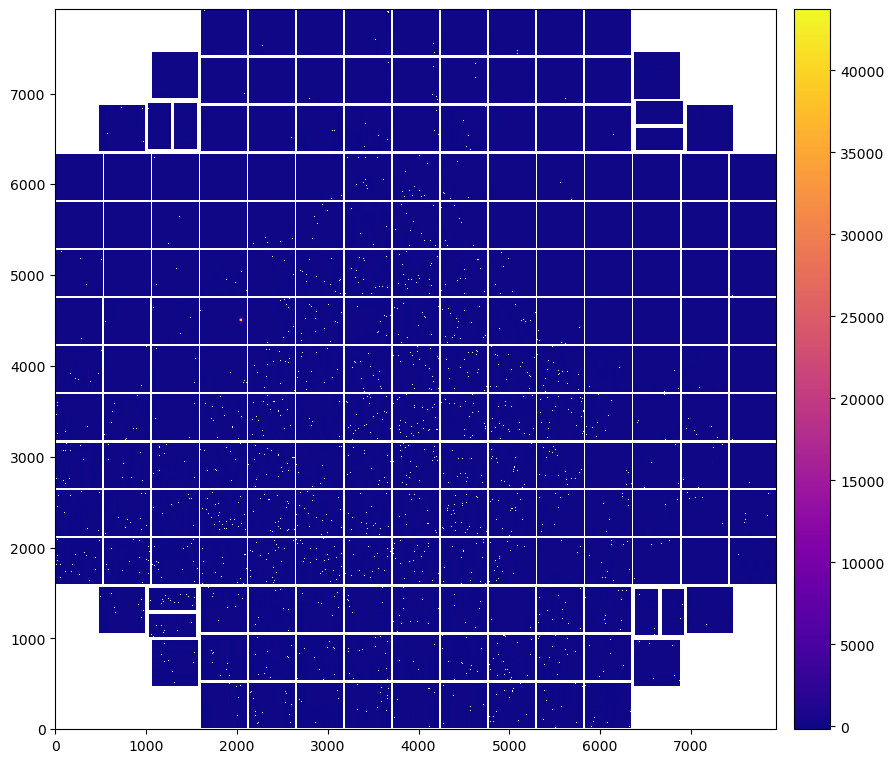

In [10]:
fig = show_mosaic(mosaic)
fig.savefig(f"{obs_id_to_process}_{imgtag}.png")

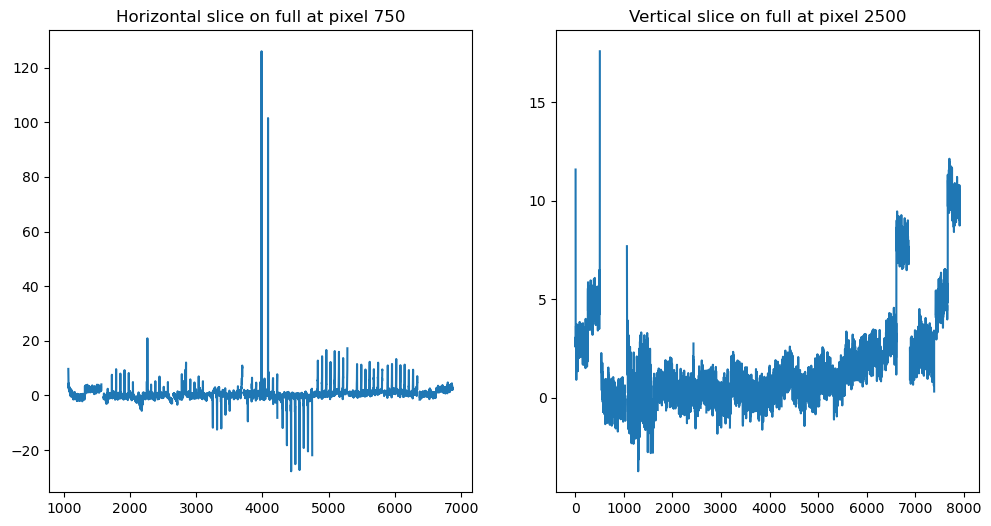

In [11]:
show_hv_slices(array_from_mosaic(mosaic), 750, 2500, 'full')

In [12]:
mosaic.writeFits(f"{obs_id_to_process}_{imgtag}.fits")

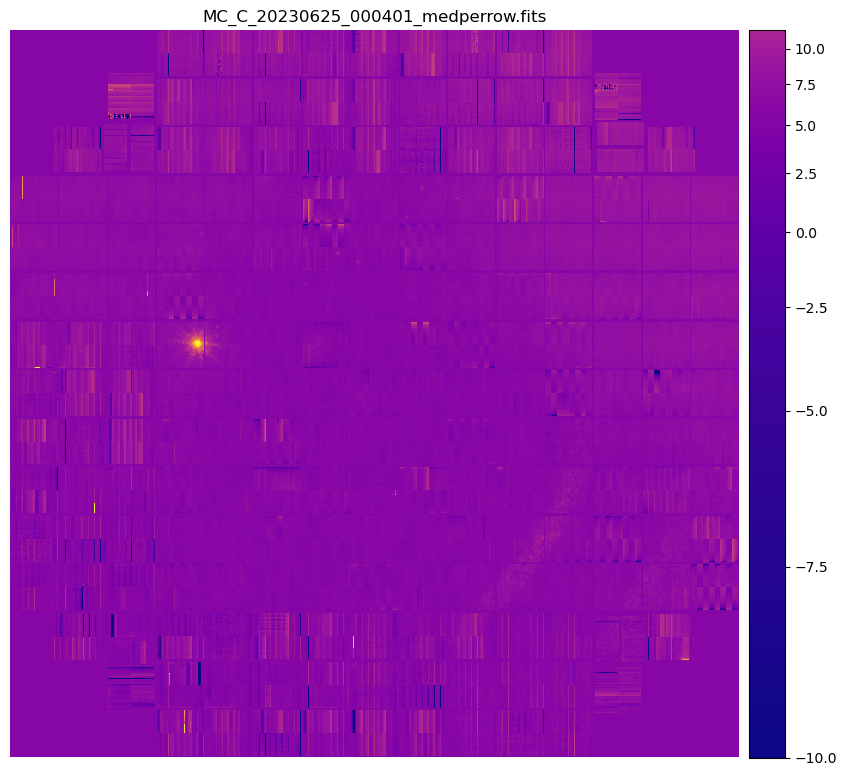

In [13]:
adisp = displayImage(mosaic, f'{obs_id_to_process}_{imgtag}.fits')

In [14]:
adisp.savefig(f"{obs_id_to_process}_{imgtag}_nice_color.png")

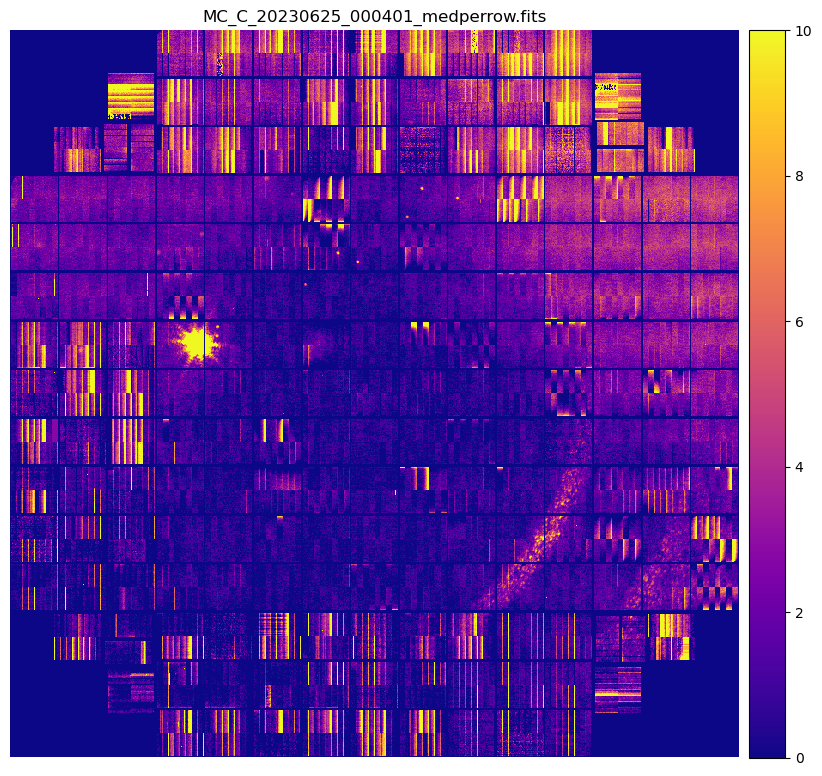

In [15]:
adisp2 = displayImageGhosts(mosaic, f'{obs_id_to_process}_{imgtag}.fits')